### Load Packages

In [699]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyprojroot import here

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

import scipy
from scipy.stats import skew

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [700]:
# load csv files
train_df = pd.read_csv(here('projects/titanic_survival_classification/data/train.csv'))
test_df = pd.read_csv(here('projects/titanic_survival_classification/data/test.csv'))

# change column names to be more descriptive and user friendly
train_col_names = ['PassengerId', 'Survived', 'Ticket Class', 'Name', 'Sex', 
                   'Age', 'Siblings and Spouses', 'Parents and Children', 'Ticket', 'Fare', 
                   'Cabin', 'Embarked']
train_df.columns = train_col_names

test_df_col_names = ['PassengerId','Ticket Class', 'Name', 'Sex', 'Age', 
                     'Siblings and Spouses', 'Parents and Children', 'Ticket', 'Fare', 'Cabin', 
                     'Embarked']    
test_df.columns = test_df_col_names

# combined data
data_df = train_df.append(test_df).reset_index(drop = True)

### Create Modeling Features

In [701]:
# --------------------------------------------------
# add survived description
# --------------------------------------------------
survived_description = []
for i in range(len(train_df['Survived'])):
    if train_df['Survived'][i] == 0:
        survived_description.append('Did Not Survive')
    else:
        survived_description.append('Survived')

train_df['Survived Description'] = survived_description

# --------------------------------------------------
# imputing ages based on titles in name
# --------------------------------------------------
data_df['Title'] = data_df['Name']

# extracting title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand = True)

# replacing unique titles
title_mapping = {
    'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 
    'Mme': 'Miss', 'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 
    'Ms': 'Miss', 'Dona': 'Mrs'
}
data_df.replace({'Title': title_mapping}, inplace = True)
title_agd_df = data_df.groupby('Title').agg({'Age': 'median'}).reset_index()
data_df = data_df[['PassengerId', 'Title']]

# merging titles and ages to train and test
train_df = train_df.merge(data_df, on = 'PassengerId')
test_df = test_df.merge(data_df, on = 'PassengerId')

train_df = train_df.merge(title_agd_df, on = 'Title')
test_df = test_df.merge(title_agd_df, on = 'Title')

# unifying age columns
train_age_imputed = []

for i in range(len(train_df)):
    if train_df['Age_x'][[i]].isna().bool():
        train_age_imputed.append(train_df['Age_y'][i])
    else:
        train_age_imputed.append(train_df['Age_x'][i])
train_df['Age'] = train_age_imputed
train_df = train_df.drop(['Age_x', 'Age_y'], axis = 1)

test_age_imputed = []

for i in range(len(test_df)):
    if test_df['Age_x'][[i]].isna().bool():
        test_age_imputed.append(test_df['Age_y'][i])
    else:
        test_age_imputed.append(test_df['Age_x'][i])
test_df['Age'] = test_age_imputed
test_df = test_df.drop(['Age_x', 'Age_y'], axis = 1)

# --------------------------------------------------
# adding features that counts number of survivors with same last name other than ones self
# --------------------------------------------------
# extract last name from name
train_df[['Last Name', 'Name']] = train_df['Name'].str.split(', ', expand = True, n = 1)
test_df[['Last Name', 'Name']] = test_df['Name'].str.split(', ', expand = True, n = 1)

survivor_df = train_df[train_df['Survived'] == 1]
survivor_df = survivor_df[['PassengerId', 'Last Name', 'Survived']]

# adding values to train
surviving_family_df = train_df[['PassengerId', 'Last Name']].merge(survivor_df, how = 'left', on = 'Last Name')

# checking to make sure survivor isn't counted towards themself
surviving_family_member_flag = []
for i in range(len(surviving_family_df)):
    if surviving_family_df['Survived'][[i]].isna().bool():
        surviving_family_member_flag.append(0)
    elif surviving_family_df['PassengerId_x'][i] != surviving_family_df['PassengerId_y'][i] and surviving_family_df['Survived'][i] == 1:
        surviving_family_member_flag.append(1)
    else:
        surviving_family_member_flag.append(0)

surviving_family_df['Surviving Family Members'] = surviving_family_member_flag
surviving_family_train_df = surviving_family_df.groupby('PassengerId_x').agg({'Surviving Family Members': 'sum'}).reset_index()
surviving_family_train_df.columns = ['PassengerId', 'Surviving Family Members']

train_df = train_df.merge(surviving_family_train_df, on = 'PassengerId')

# adding values to test
surviving_family_df = test_df[['PassengerId', 'Last Name']].merge(survivor_df, how = 'left', on = 'Last Name')

# checking to make sure survivor isn't counted towards themself
surviving_family_member_flag = []
for i in range(len(surviving_family_df)):
    if surviving_family_df['Survived'][[i]].isna().bool():
        surviving_family_member_flag.append(0)
    elif surviving_family_df['PassengerId_x'][i] != surviving_family_df['PassengerId_y'][i] and surviving_family_df['Survived'][i] == 1:
        surviving_family_member_flag.append(1)
    else:
        surviving_family_member_flag.append(0)

surviving_family_df['Surviving Family Members'] = surviving_family_member_flag
surviving_family_test_df = surviving_family_df.groupby('PassengerId_x').agg({'Surviving Family Members': 'sum'}).reset_index()
surviving_family_test_df.columns = ['PassengerId', 'Surviving Family Members']

test_df = test_df.merge(surviving_family_test_df, on = 'PassengerId')

# --------------------------------------------------
# adding feature that shows frequency of ticket number
# --------------------------------------------------
ticket_frequency = train_df.append(test_df)['Ticket'].value_counts()
ticket_frequency_df = pd.DataFrame(ticket_frequency).reset_index()
ticket_frequency_df.columns = ['Ticket', 'Ticket Frequency']

train_df = train_df.merge(ticket_frequency_df, how = 'left', on = ['Ticket'])
test_df = test_df.merge(ticket_frequency_df, how = 'left', on = ['Ticket'])

# --------------------------------------------------
# adding feature that shows frequency of fare price
# --------------------------------------------------
fare_frequency = train_df.append(test_df)['Fare'].value_counts()
fare_frequency_df = pd.DataFrame(fare_frequency).reset_index()
fare_frequency_df.columns = ['Fare', 'Fare Frequency']

train_df = train_df.merge(fare_frequency_df, how = 'left', on = ['Fare'])
test_df = test_df.merge(fare_frequency_df, how = 'left', on = ['Fare'])

# --------------------------------------------------
# adding feature the shows relatives
# --------------------------------------------------
train_df['Relatives'] = train_df['Siblings and Spouses'] + train_df['Parents and Children']
test_df['Relatives'] = test_df['Siblings and Spouses'] + test_df['Parents and Children']

In [702]:
# limiting data to populations that need to be predicted
# females in 1st and 2nd class survived ~94% of the time in train data - will predict that all survive
test_df_auto_predictions = test_df[(test_df['Sex'] == 'female') & ((test_df['Ticket Class'] == 1) | (test_df['Ticket Class'] == 2))]
test_df_auto_predictions['Survived Prediction'] = [1] * len(test_df_auto_predictions)
train_df = train_df[((train_df['Sex'] == 'female') & (train_df['Ticket Class'] == 3)) | (train_df['Sex'] == 'male')]
test_df = test_df[((test_df['Sex'] == 'female') & (test_df['Ticket Class'] == 3)) | (test_df['Sex'] == 'male')]

## Exploratory Data Analysis
---

### Survived vs Did Not Survive

Percent Survived: 74.9%
Percent Did Not Survive: 25.1%


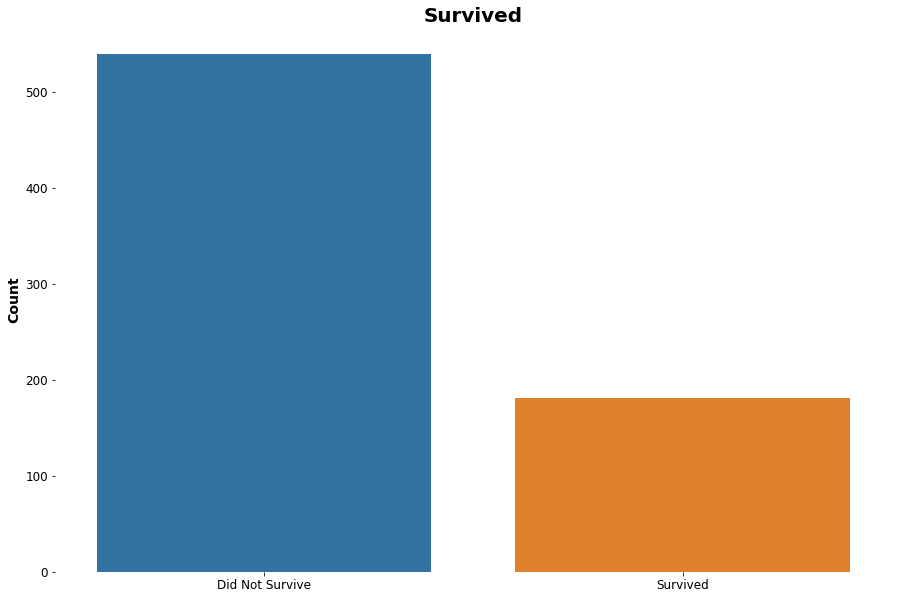

In [703]:
print('Percent Survived: ' ,round((len(train_df[train_df['Survived'] == 0]) / len(train_df)) * 100, 2), '%', sep = '')
print('Percent Did Not Survive: ' ,round((len(train_df[train_df['Survived'] == 1]) / len(train_df)) * 100, 2), '%', sep = '')

plt.figure(figsize = (15, 10))
plt.title('Survived', fontdict = {'size': 20, 'weight': 'bold'})
sns.countplot(x = train_df['Survived Description'])
plt.legend('', framealpha = 0)
plt.box(False)
plt.ylabel('Count', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(fontsize = 12)
plt.xlabel('')
plt.xticks(fontsize = 12)
plt.show()

### NAs in Data Set

                      Column  Count_NA  Percent_NA
0                PassengerId         0    0.000000
1                   Survived         0    0.000000
2               Ticket Class         0    0.000000
3                       Name         0    0.000000
4                        Sex         0    0.000000
5       Siblings and Spouses         0    0.000000
6       Parents and Children         0    0.000000
7                     Ticket         0    0.000000
8                       Fare         0    0.000000
9                      Cabin       608    0.843273
10                  Embarked         0    0.000000
11      Survived Description         0    0.000000
12                     Title         0    0.000000
13                       Age         0    0.000000
14                 Last Name         0    0.000000
15  Surviving Family Members         0    0.000000
16          Ticket Frequency         0    0.000000
17            Fare Frequency         0    0.000000
18                 Relatives   

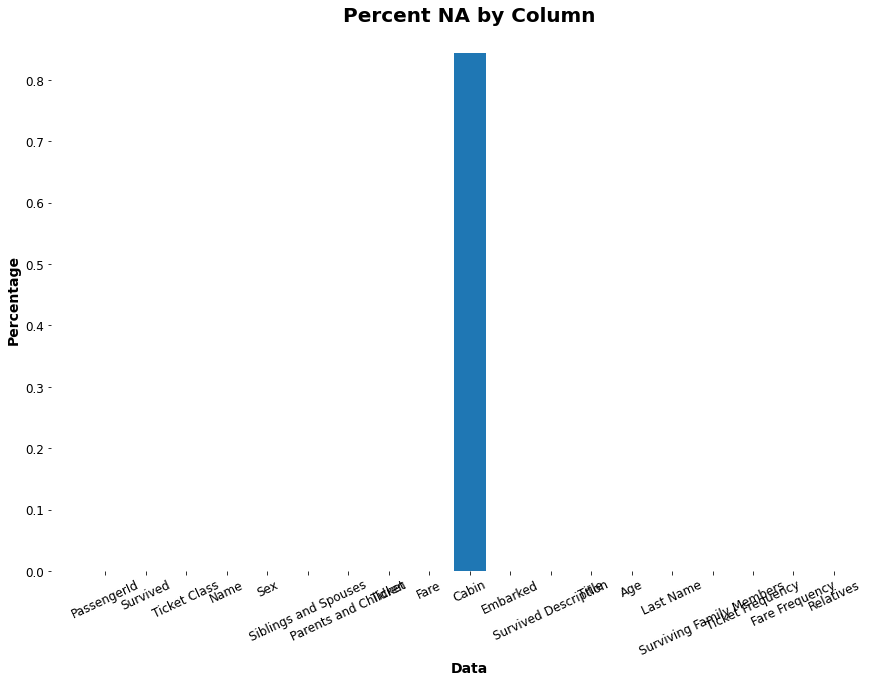

In [704]:
cols = []
count_na = []
percent_na = []

for i in range(len(train_df.isnull().sum(axis = 0))):
    cols.append(train_df.columns[i])
    count_na.append(train_df.isnull().sum(axis = 0)[i])
    percent_na.append(train_df.isnull().sum(axis = 0)[i] / len(train_df))
    
na_by_column = pd.DataFrame(
    {
        'Column': cols,
        'Count_NA': count_na,
        'Percent_NA': percent_na
    }
)

print(na_by_column)

plt.figure(figsize = [15, 10])
plt.bar(data = na_by_column, x = 'Column', height = 'Percent_NA')
plt.box(False)
plt.xlabel('Data', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(fontsize = 12, rotation = 25)
plt.ylabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(fontsize = 12)
plt.title('Percent NA by Column', fontdict = {'size': 20, 'weight': 'bold'})
plt.show()

### Numerical Variables

In [705]:
num_cols = ['Age', 'Ticket Class', 'Ticket Frequency', 'Relatives', 'Fare', 'Fare Frequency', 'Surviving Family Members']
categorical_cols = ['Ticket Class', 'Sex', 'Embarked']

Age
--------------------
Skew : 0.51
Mean: 28.88
Median: 30.0
Standard Deviation: 13.19
Percent NA: 0.0%

Mean (Survived): 24.9
Mean (Did Not Survive): 30.21


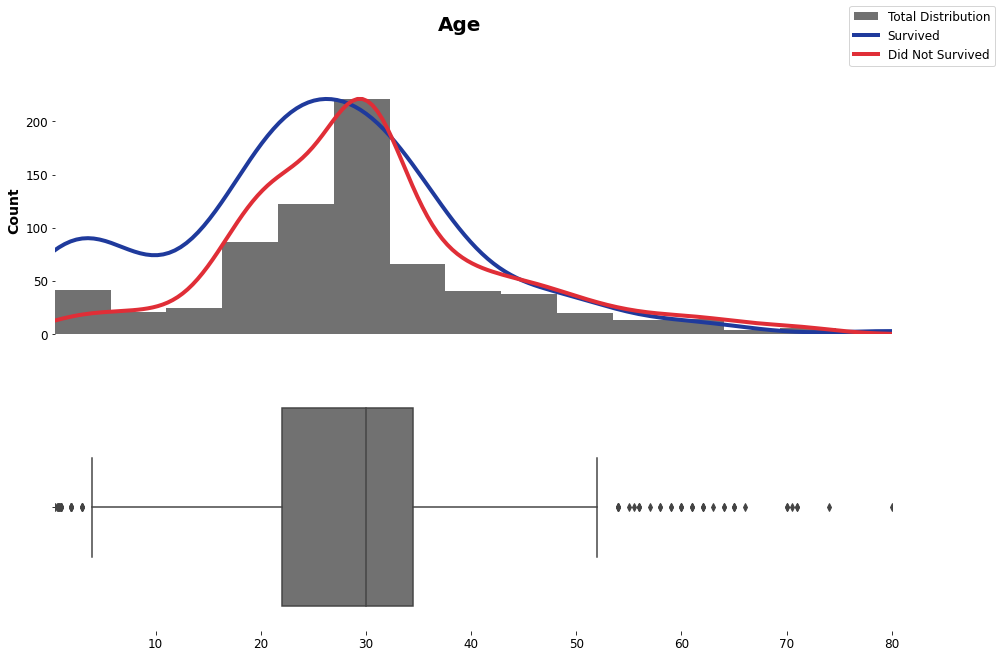

Ticket Class
--------------------
Skew : -1.17
Mean: 2.51
Median: 3.0
Standard Deviation: 0.77
Percent NA: 0.0%

Mean (Survived): 2.41
Mean (Did Not Survive): 2.55


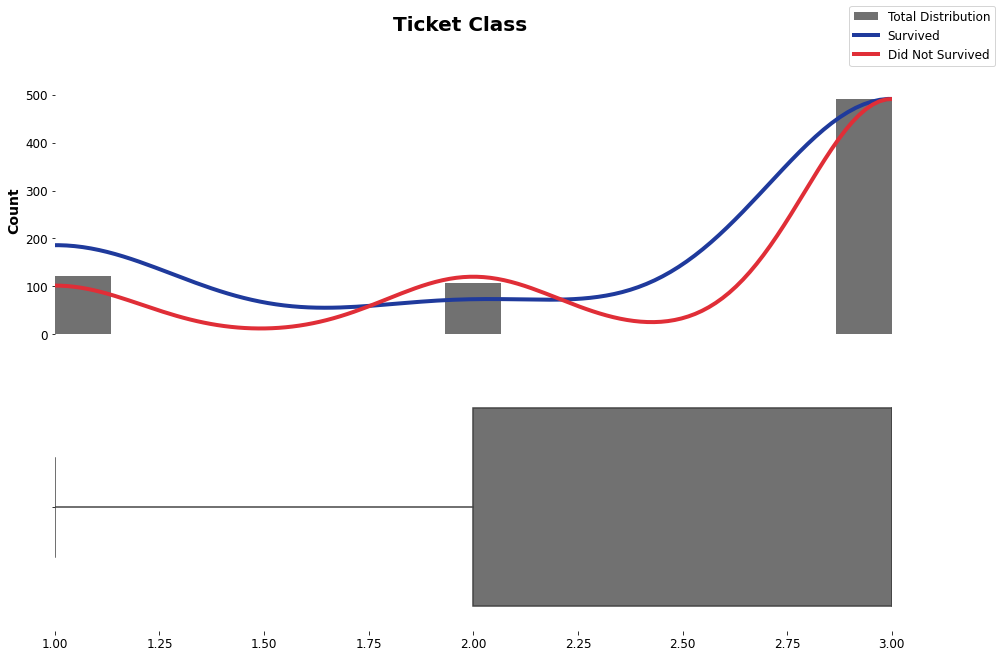

Ticket Frequency
--------------------
Skew : 2.42
Mean: 2.03
Median: 1.0
Standard Deviation: 1.88
Percent NA: 0.0%

Mean (Survived): 2.06
Mean (Did Not Survive): 2.02


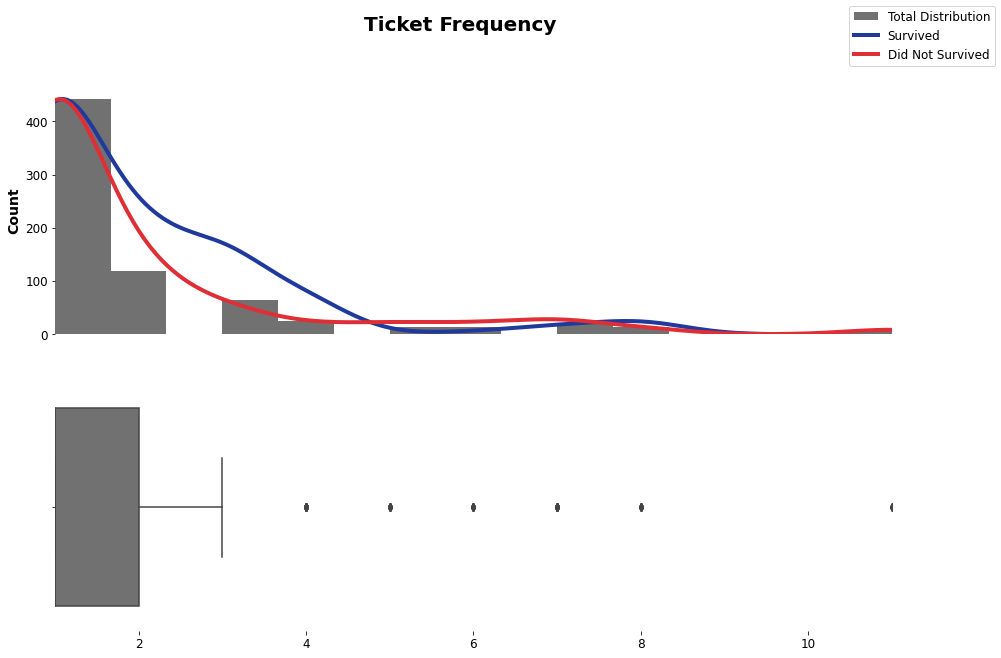

Relatives
--------------------
Skew : 2.81
Mean: 0.87
Median: 0.0
Standard Deviation: 1.7
Percent NA: 0.0%

Mean (Survived): 0.85
Mean (Did Not Survive): 0.88


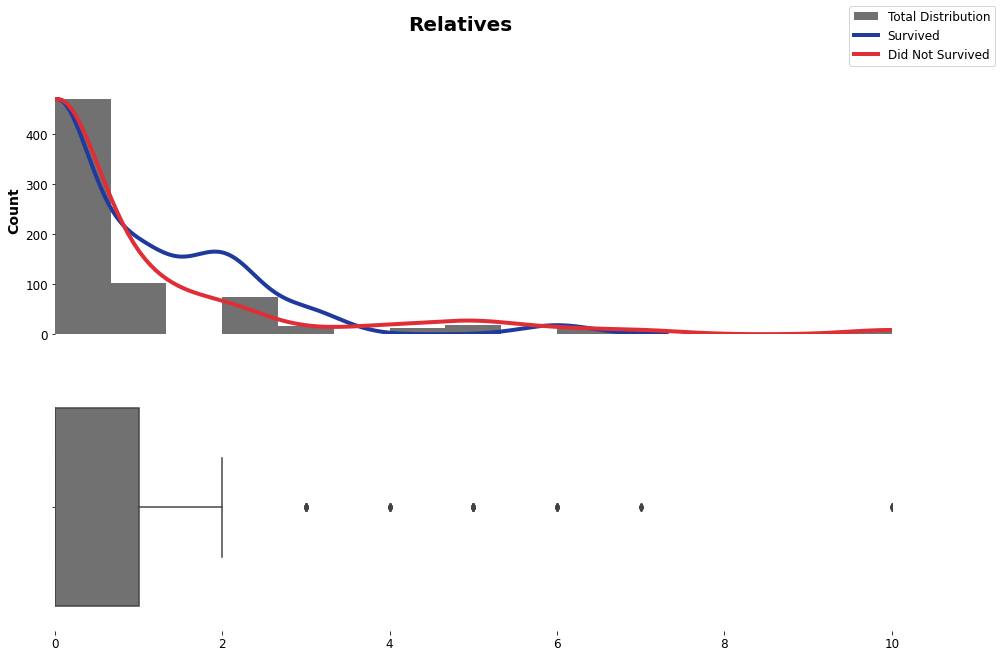

Fare
--------------------
Skew : 7.24
Mean: 23.65
Median: 11.24
Standard Deviation: 39.09
Percent NA: 0.0%

Mean (Survived): 29.54
Mean (Did Not Survive): 21.67


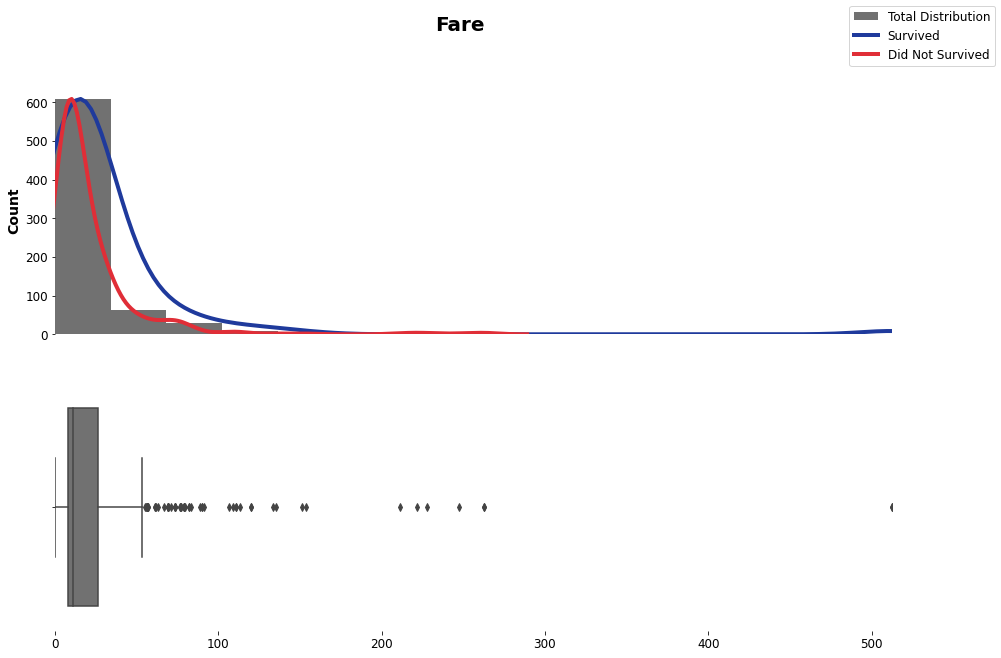

Fare Frequency
--------------------
Skew : 0.96
Mean: 19.85
Median: 10.0
Standard Deviation: 20.44
Percent NA: 0.0%

Mean (Survived): 15.24
Mean (Did Not Survive): 21.4


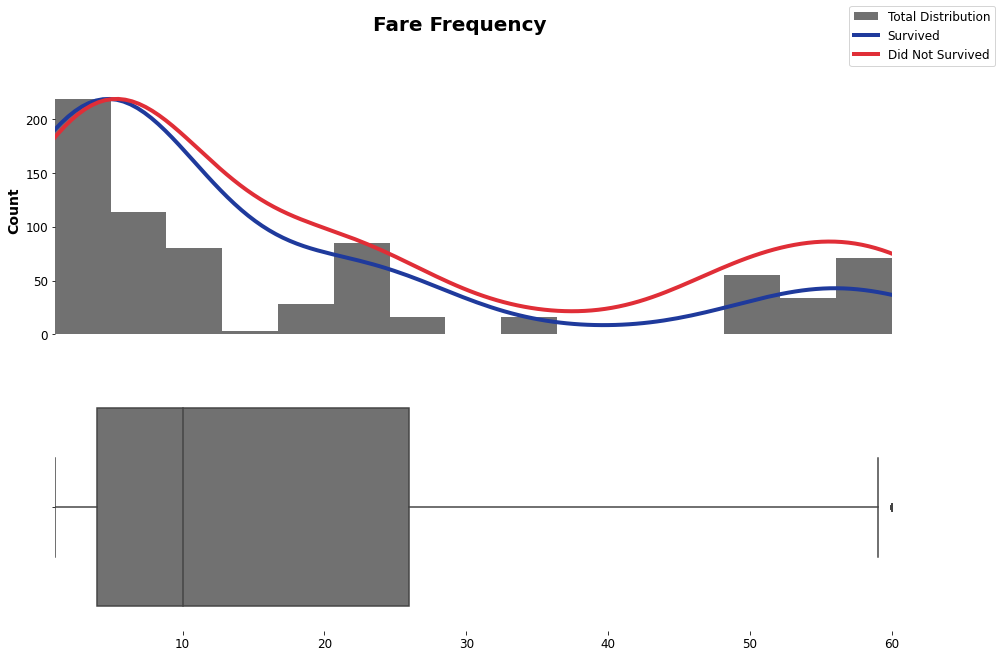

Surviving Family Members
--------------------
Skew : 2.63
Mean: 0.27
Median: 0.0
Standard Deviation: 0.65
Percent NA: 0.0%

Mean (Survived): 0.45
Mean (Did Not Survive): 0.21


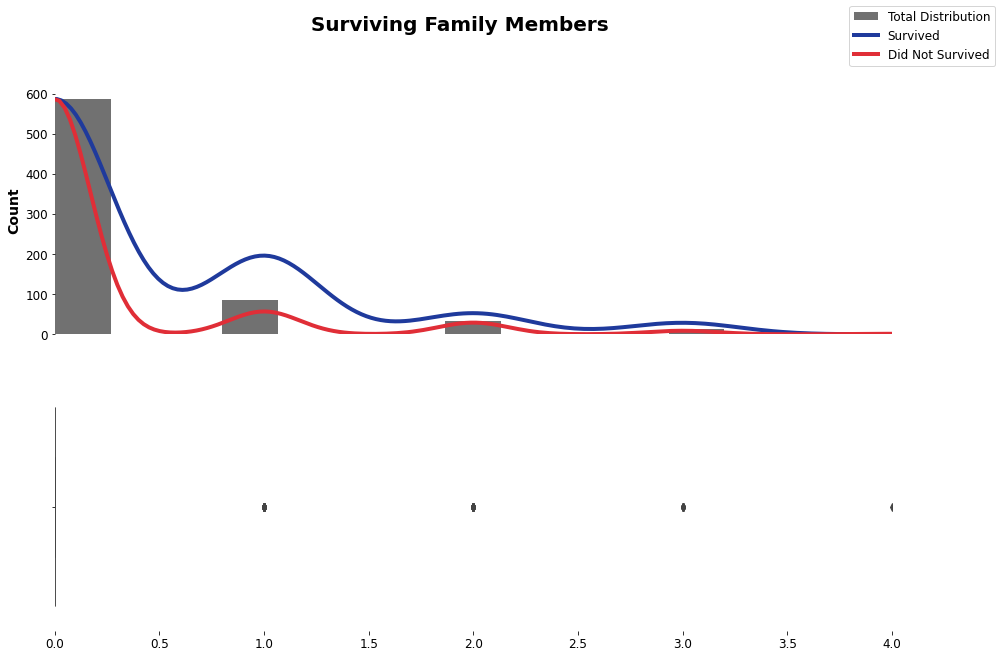

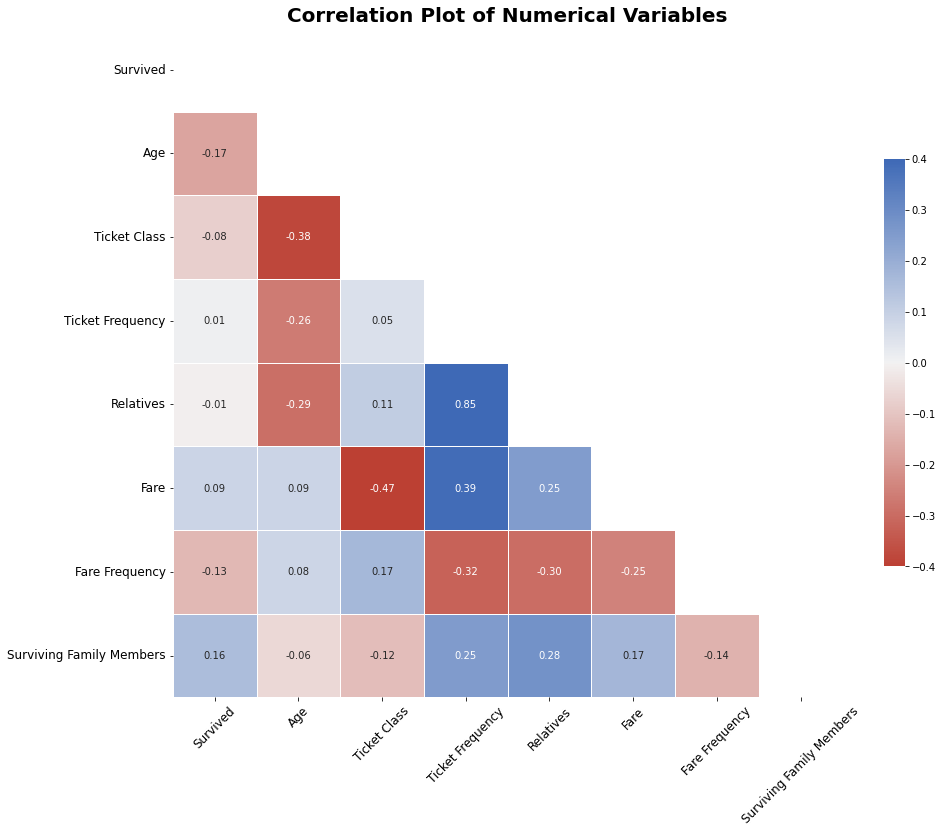

In [706]:
survived_train_df = train_df[train_df['Survived'] == 1]
died_train_df = train_df[train_df['Survived'] == 0]

for col in num_cols:
    print(col)
    
    # descriptive statistics
    print('--------------------')
    
    print('Skew :',round(train_df[col].skew(), 2))
    print('Mean:', '{:,}'.format(round(np.mean(train_df[col]), 2)))
    print('Median:', '{:,}'.format(round(np.nanmedian(train_df[col]), 2)))
    print('Standard Deviation:', '{:,}'.format(round(np.std(train_df[col]), 2)))
    print('Percent NA: ', round((train_df[col].isnull().sum() / len(train_df)) * 100, 2), '%', sep = '')
    print()
    print('Mean (Survived):', '{:,}'.format(round(np.mean(survived_train_df[col]), 2)))
    print('Mean (Did Not Survive):', '{:,}'.format(round(np.mean(died_train_df[col]), 2)))
    
    plt.figure(figsize = (15, 10))
    plt.suptitle(col, size = 20, weight = 'bold')
    
    # plot 1: histogram and density plot
    plt.subplot(2, 1, 1)
    
    plt.hist(x = train_df[col], bins = 15, color = '#717171', label = 'Total Distribution')
    plt.xlim(np.min(train_df[col]), np.max(train_df[col]))
    plt.box(False)
    plt.ylabel('Count', fontdict = {'size': 14, 'weight': 'bold'})
    plt.yticks(fontsize = 12)
    plt.xticks(labels = [], ticks = [])
    
    plt.twinx()
    sns.kdeplot(x = survived_train_df[col], color = '#1F3A9C', linewidth = 4, label = 'Survived')
    plt.box(False)
    plt.ylabel('')
    plt.yticks(labels = [], ticks = [])
    plt.xticks(labels = [], ticks = [])
    
    plt.twinx()
    sns.kdeplot(x = died_train_df[col], color = '#E02E37', linewidth = 4, label = 'Did Not Survived')
    plt.box(False)
    plt.ylabel('')
    plt.yticks(labels = [], ticks = [])
    plt.xticks(labels = [], ticks = [])
    plt.figlegend(fontsize = 12)
    
    # plot 2: boxplot
    plt.subplot(2, 1, 2)
    sns.boxplot(x = train_df[col], color = '#717171')
    plt.box(False)
    plt.xlim(np.min(train_df[col]), np.max(train_df[col]))
    plt.xlabel('')
    plt.xticks(fontsize = 12)
    plt.show()
    
# correlation plot
plt.figure(figsize = (15, 15))

corr_col = ['Survived', 'Age', 'Ticket Class', 'Ticket Frequency', 'Relatives', 'Fare', 'Fare Frequency', 'Surviving Family Members']
num_corr = train_df[corr_col].corr()
num_mask = np.triu(np.ones_like(num_corr, dtype=bool))
cmap = sns.diverging_palette(h_neg = 15, h_pos = 255, s = 75, l = 45, sep = 1, center = 'light', as_cmap = True)

sns.heatmap(num_corr, mask = num_mask, cmap = cmap, vmin = -.4, vmax=.4, center=0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": .5}, annot = True, fmt = ".2f")
plt.title('Correlation Plot of Numerical Variables', fontdict = {'size': 20, 'weight': 'bold'})
plt.xticks(fontsize = 12, rotation = 45)
plt.yticks(fontsize = 12)
plt.show()


### Categorical Variables

Ticket Class
--------------------
Percent NA: 0.0%


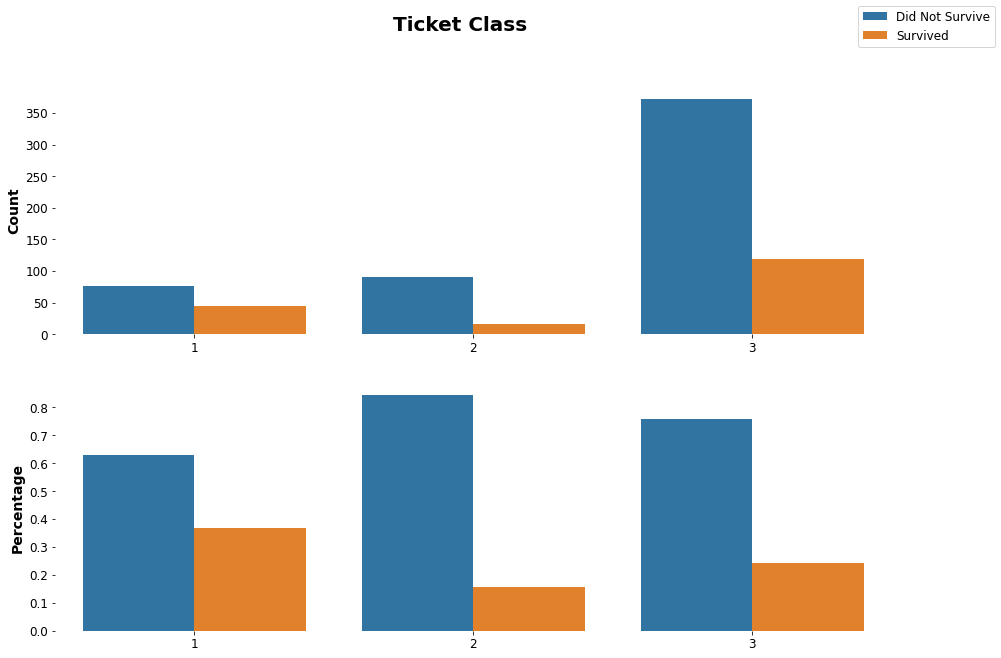

Sex
--------------------
Percent NA: 0.0%


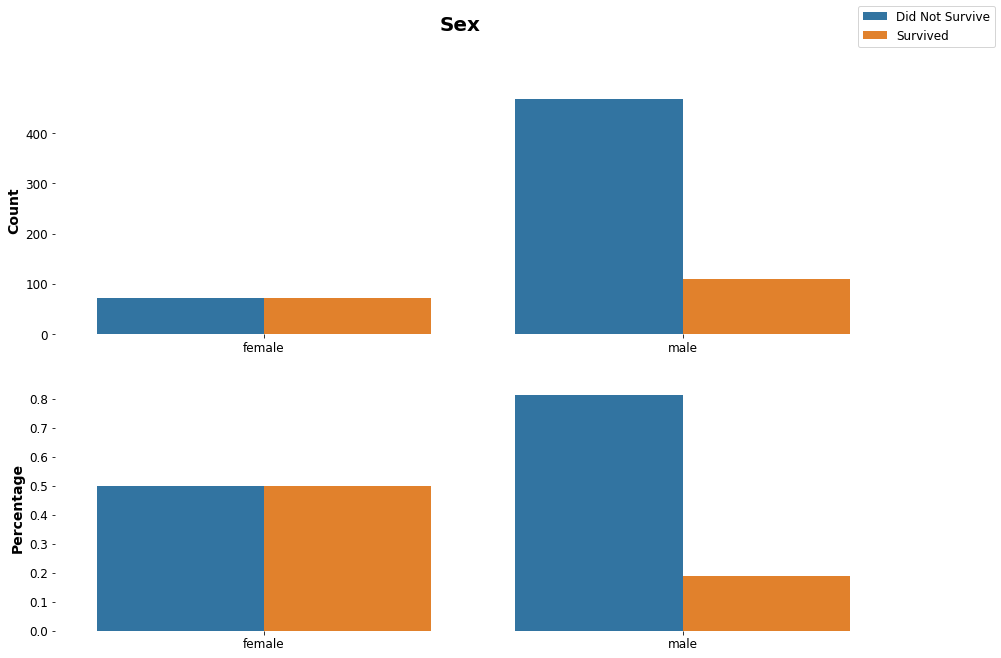

Embarked
--------------------
Percent NA: 0.0%


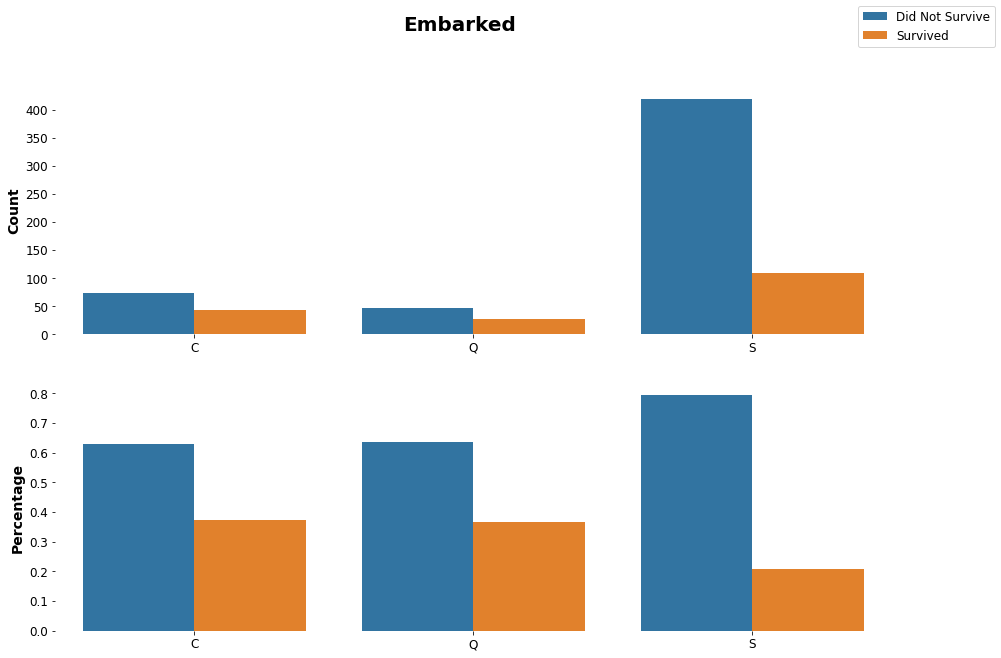

In [707]:
for col in categorical_cols:
    # creating dictionary for visualization x axis order
    categorical_cols = ['Ticket Class', 'Sex',  'Embarked']
    
    label_dic = {
        'Ticket Class': [1, 2, 3],
        'Sex': ['female', 'male'],
        'Cabin Letter': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'],
        'Embarked': ['C', 'Q', 'S']
    }
    
    # descriptive statistics
    print(col)
    print('--------------------')
    print('Percent NA: ', round((train_df[col].isnull().sum() / len(train_df)) * 100, 2), '%', sep = '')
    
    # create dataframe for plots
    counts_total = pd.DataFrame(train_df.groupby([col]).count()['PassengerId']).reset_index()
    counts = pd.DataFrame(train_df.groupby([col,'Survived Description']).count()['PassengerId']).reset_index()
    counts = pd.merge(counts, counts_total, on = col, suffixes = ['', '_Total'])
    counts['Percentage_By_Column'] = counts['PassengerId'] / counts['PassengerId_Total']
    
    # plot 1: bar plot counts
    plt.figure(figsize = (15, 10))
    plt.suptitle(col, size = 20, weight = 'bold')
    
    plt.subplot(2, 1, 1)

    sns.barplot(x = counts[col], y = counts['PassengerId'], hue = counts['Survived Description'], order = label_dic[col])
    plt.legend('', framealpha = 0)
    plt.box(False)
    plt.xlabel('')
    plt.xticks(fontsize = 12)
    plt.ylabel('Count', fontdict = {'size': 14, 'weight': 'bold'})
    plt.yticks(fontsize = 12)
    plt.figlegend(fontsize = 12)
    
    # plot 2: bar plot  percentages
    plt.subplot(2, 1, 2)
    
    sns.barplot(x = counts[col], y = counts['Percentage_By_Column'], hue = counts['Survived Description'], order = label_dic[col])
    plt.legend('', framealpha = 0)
    plt.box(False)
    plt.xlabel('')
    plt.xticks(fontsize = 12)
    plt.ylabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
    plt.yticks(fontsize = 12)
    
    plt.show()


## Preprocessing Data
---

I want to be able to use a logistic regression and a knn classifier model to build base models on my dataset, so preprocessing that data will be important. I have found the doing a power transformation and a center and scale generally helps with both linear and non-linear models, so I did that here. I also used a knn imputer because of 1 missing value in the test dataset.

In [564]:
# removing features
train_df = train_df.drop(['Siblings and Spouses', 'Parents and Children', 'Cabin'], axis = 1)
test_df = test_df.drop(['Siblings and Spouses', 'Parents and Children', 'Cabin'], axis = 1)

In [708]:
# responce
train_y = train_df['Survived']

# gathering features
features = ['Ticket Class', 'Ticket Frequency', 'Sex', 'Age', 'Fare', 'Fare Frequency', 'Embarked', 'Surviving Family Members']

train_x = train_df[features]
test_x = test_df[features]

# creating dummy variables
train_x_dummies = pd.get_dummies(train_x[['Sex', 'Embarked']])
train_x = pd.concat([train_x, train_x_dummies], axis=1)
train_x.drop(['Sex', 'Embarked'], inplace = True, axis = 1)

test_x_dummies = pd.get_dummies(test_x[['Sex', 'Embarked']])
test_x = pd.concat([test_x, test_x_dummies], axis=1)
test_x.drop(['Sex', 'Embarked'], inplace = True, axis = 1)

# power transform data
power_scale_cols = ['Ticket Class', 'Ticket Frequency', 'Age', 'Fare', 'Fare Frequency', 'Surviving Family Members']

power_features_train = train_x[power_scale_cols]
power_features_test = test_x[power_scale_cols]
power_trans =  PowerTransformer().fit(power_features_train.values)

train_x[power_scale_cols] = power_trans.transform(power_features_train.values)
test_x[power_scale_cols] = power_trans.transform(power_features_test.values)

# center and scale data
scale_features_train = train_x[power_scale_cols]
scale_features_test = test_x[power_scale_cols]
scaler = StandardScaler().fit(scale_features_train.values)

train_x[power_scale_cols] = scaler.transform(scale_features_train.values)
test_x[power_scale_cols] = scaler.transform(scale_features_test.values)
    
# impute missing values
train_x_columns = train_x.columns
test_x_columns = test_x.columns

knn_imputer = KNNImputer(n_neighbors = 25, weights = 'uniform').fit(train_x)

train_x = knn_imputer.transform(train_x)
train_x = pd.DataFrame(train_x, columns = train_x_columns)

test_x = knn_imputer.transform(test_x)
test_x = pd.DataFrame(test_x, columns = test_x_columns)

# printing features and outcome distribution  
print("Feature training set dimensions: ", train_x.shape)   
print("Feature test set dimensions:", test_x.shape)
print("Features:")
for i in train_x.columns:
    print(' -',i)
print()

print("Responce distribution training set:")
print(train_y.value_counts(normalize = True))
print()

Feature training set dimensions:  (721, 11)
Feature test set dimensions: (338, 11)
Features:
 - Ticket Class
 - Ticket Frequency
 - Age
 - Fare
 - Fare Frequency
 - Surviving Family Members
 - Sex_female
 - Sex_male
 - Embarked_C
 - Embarked_Q
 - Embarked_S

Responce distribution training set:
0    0.74896
1    0.25104
Name: Survived, dtype: float64



## Developing Classification Models
---

I had a very difficult time building a model that would perform better than the base accuracy from attained from the imbalance in the dataset. Because females in 1st and 2nd class were taken out of the test and train datasets, the imbalance was made even worse than it originally was. Using SVM, Gradient Boosting, and other more complex models would generally produce poor accuracies, hardly if at all better than a linear model or a knn, or it would predict all passengers did not survive. 

I chose to build an ensamble model that would take in the binary predictions of the logistic regression model and the knn model as inputs, along with the existing features, and make a new prediction. My idea is that the logistic regression prediction would capture the linear relationships, the knn would capture the non-linear relationships, and the final model, which ended up being a neural network, could learn the where each model did well and where each did poorly.

In [619]:
# creating function to easily fit models
def fit_classification_model(name, model, parameters, x, y):
    # fit model based on parameters given
    grid_obj = GridSearchCV(model, parameters, scoring = metrics.make_scorer(accuracy_score), cv = 5)
    grid_obj = grid_obj.fit(x, y)
    model = grid_obj.best_estimator_
    
    model_fits = pd.DataFrame(grid_obj.cv_results_)
    model_fits = model_fits.sort_values('rank_test_score').reset_index(drop = True)
    
    # saving model accuracy and error
    model_accuracy = model_fits['mean_test_score'][0]
    model_error = model_fits['std_test_score'][0]
    
    # saving model fits, accuracy, and error as model attributes
    model.fits = model_fits
    model.accuracy = model_accuracy
    model.error = model_error
    
    # make predictions on dataset and store them in train dataframe
    pred_prob = model.predict(x)
    pred_prob_col = name + '_predict'
    
    pred_df = x.copy()
    pred_df[pred_prob_col] = pred_prob
    
    return(model, pred_df)

In [620]:
# creating function to easily make predictions from models
def execute_classification_model(name, model, x):
    # make predictions on dataset and store them in train dataframe
    pred_prob = model.predict(x)
    pred_prob_col = name + '_predict'
    
    pred_df = x.copy()
    pred_df[pred_prob_col] = pred_prob
    
    return(pred_df)

In [718]:
# limiting model features
model_features = ['Age', 'Ticket Class', 'Ticket Frequency', 'Fare Frequency', 'Surviving Family Members', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
train_x = train_x[model_features]
test_x = test_x[model_features]

### Logistic Regression

In [719]:
np.random.seed(101010)

logit_parameters = {
    'class_weight': [{0: 0.45, 1: 0.55}],
    'penalty': ['l2'],
    'max_iter': [1000],
    'tol': [1e-2],
    'C': [5],
    'solver': ['sag']
    }

logit, logit_predictions_df = fit_classification_model('logit', LogisticRegression(), logit_parameters, train_x, train_y)
logit_test_predictions = execute_classification_model('logit', logit, test_x)
print('Accuracy')
print(np.round(logit.accuracy * 100, 2), '%', sep = '')

Accuracy
67.12%


### KNN

In [720]:
np.random.seed(101010)

knn_parameters = {
    'algorithm': ['auto'],
    'metric': ['minkowski'],
    'n_neighbors': [10],
    'p': [2],
    'weights': ['uniform']
}

knn, knn_predictions_df = fit_classification_model('knn', KNeighborsClassifier(), knn_parameters, train_x, train_y)
knn_test_predictions = execute_classification_model('knn', knn, test_x)
print('Accuracy')
print(np.round(knn.accuracy * 100, 2), '%', sep = '')

Accuracy
70.45%


### Neural Network

In [734]:
# adding predictions from logit and knn to be used in neural network
train_predictions_x = train_x.copy()
train_predictions_x['logit_predict'] = logit_predictions_df['logit_predict']
train_predictions_x['knn_predict'] = knn_predictions_df['knn_predict']

test_predictions_x = test_x.copy()
test_predictions_x['logit_predict'] = logit_test_predictions['logit_predict']
test_predictions_x['knn_predict'] = knn_test_predictions['knn_predict']

In [722]:
np.random.seed(101010)

nn_parameters = {
    'hidden_layer_sizes': [(128)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [1e-4],
    'learning_rate_init': [7e-5],
    'learning_rate': ['adaptive'],
    'tol': [1e-4]
}

nn, nn_predictions_df = fit_classification_model('nn', MLPClassifier(), nn_parameters, train_predictions_x, train_y)
nn_test_predictions = execute_classification_model('nn', nn, test_predictions_x)
nn_test_y_pred = nn.predict(test_predictions_x)
print('Accuracy')
print(np.round(nn.accuracy * 100, 2), '%', sep = '')

Accuracy
74.62%


## Evaluating Features

### Linear Relationships

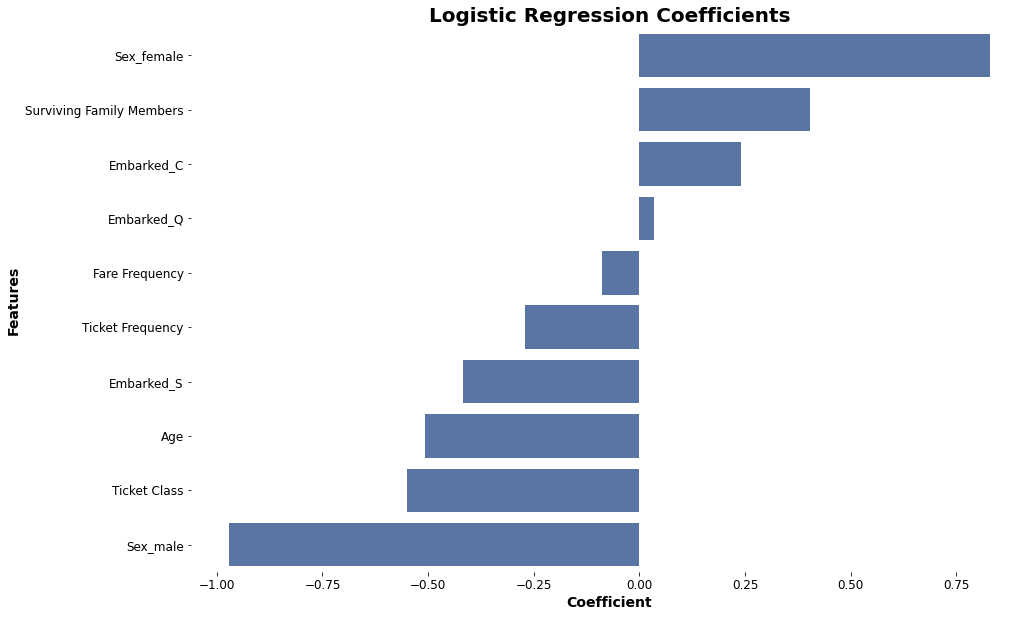

In [723]:
# plot model coefficients
log_coefficients = []

for i in range(len(train_x.columns)):
    log_coefficients.append(np.float32(logit.coef_[:,i][0]))
    
log_coef_df = pd.DataFrame(
    {
        'Feature': train_x.columns,
        'Coefficient': log_coefficients
    }
)

plt.figure(figsize = (15, 10))
log_coef_df = log_coef_df.sort_values('Coefficient', ascending = False)

sns.barplot(data = log_coef_df, x = 'Coefficient', y = 'Feature', color = '#4C72B0')
plt.title('Logistic Regression Coefficients', fontdict = {'size': 20, 'weight': 'bold'})
plt.box(False)
plt.xlabel('Coefficient', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(fontsize = 12)
plt.ylabel('Features', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(fontsize = 12)
plt.show()

### Principal Components

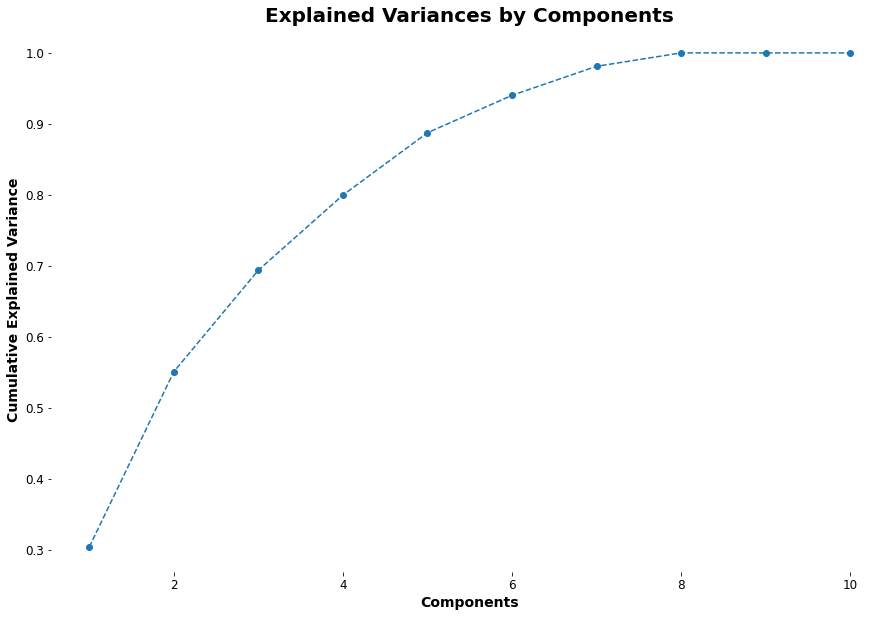

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10
Age,-0.293250,0.628662,-0.052671,-0.506673,0.508900,-0.000932,-0.008704,-0.015530,0.000000,0.000000
Ticket Class,-0.103507,-0.717175,-0.032963,-0.569588,0.249499,-0.158527,-0.241342,-0.061661,-0.000000,0.000000
Ticket Frequency,0.629738,-0.042912,0.023648,0.287929,0.704458,0.033775,-0.133202,0.054605,-0.000000,-0.000000
Fare Frequency,-0.492973,-0.149087,0.731439,0.306850,0.281096,0.158222,0.024806,-0.030431,0.000000,0.000000
Surviving Family Members,0.502372,0.156698,0.671389,-0.435878,-0.269219,-0.081239,0.041024,-0.039421,0.000000,0.000000
Sex_female,0.062891,-0.137666,-0.060683,-0.116416,0.091468,0.295997,0.593226,-0.109360,-0.707016,0.011331
Sex_male,-0.062891,0.137666,0.060683,0.116416,-0.091468,-0.295997,-0.593226,0.109360,-0.707016,0.011331
Embarked_C,0.045309,0.042377,-0.040199,-0.016810,-0.069518,0.463773,-0.329370,-0.576643,0.009251,0.577276
Embarked_Q,-0.009809,-0.045929,0.016523,-0.101761,-0.024546,0.239407,-0.001260,0.771954,0.009251,0.577276
Embarked_S,-0.035501,0.003552,0.023676,0.118571,0.094064,-0.703181,0.330630,-0.195311,0.009251,0.577276


In [724]:
np.random.seed(101010)

n_components = train_x.shape[1]
pca = PCA(n_components)
pca_df = pd.DataFrame(pca.fit_transform(train_x))
pca_explained_variance = pca.explained_variance_ratio_

# plot to some cumulative explained variance
plt.figure(figsize = (15, 10))

plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variances by Components', fontdict = {'size': 20, 'weight': 'bold'})
plt.box(False)
plt.xlabel('Components', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(fontsize = 12)
plt.ylabel('Cumulative Explained Variance', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(fontsize = 12)

plt.show()

# print dataframe of features in each principal component
pca_cols = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9', 'PC 10']
pca_df = pd.DataFrame(np.round(pca.components_.T[:, 0:10], 10), index = train_x.columns, columns = pca_cols)

def pca_colors(val):
    if val <= -0.25:
        return 'background: #C44D51'
    elif val >= 0.25:
        return 'background: #4C72B0'
    
pca_df.style.applymap(pca_colors)

## Model Predictions

In [725]:
test_df['Survived Prediction'] = nn_test_y_pred
test_predictions_df = test_df.append(test_df_auto_predictions).sort_values('PassengerId').reset_index(drop = True)
submission_df = test_predictions_df[['PassengerId', 'Survived Prediction']]
submission_df.columns = ['PassengerId', 'Survived']
submission_df.to_csv(here('projects/titanic_survival_classification/data/submission_titanic_chg.csv'), index = False)

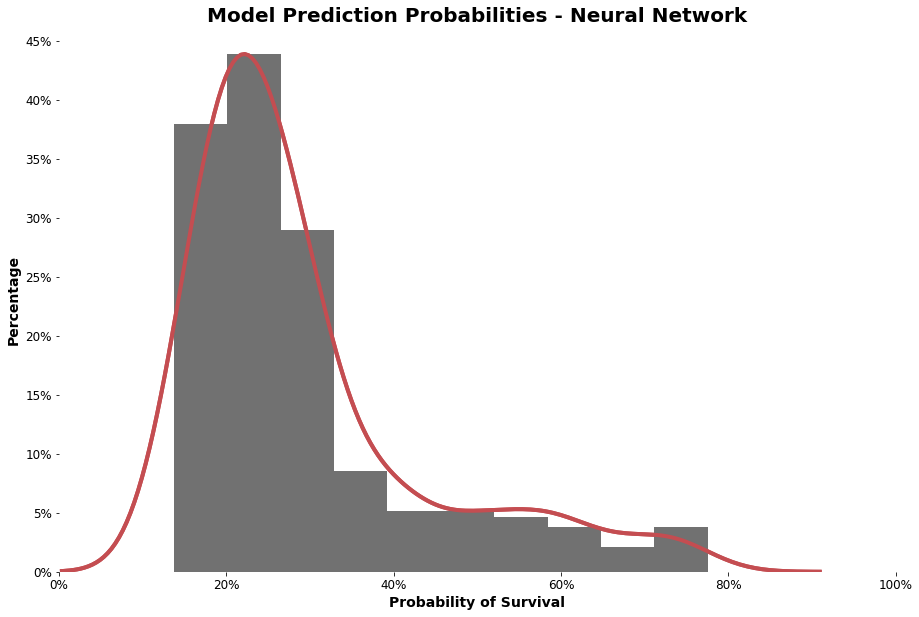

In [738]:
plt.figure(figsize = (15, 10))

nn_predict_proba = []
for i in nn.predict_proba(test_predictions_x)[:,[1]]:
    nn_predict_proba.append(i[0])

plt.title('Model Prediction Probabilities - Neural Network', fontdict = {'size': 20, 'weight': 'bold'})
sns.kdeplot(x = nn_predict_proba, color = '#C44D51', linewidth = 4, label = 'Neural Network')
plt.box(False)
plt.xlabel('Probability of Survival', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
           labels = ['0%', '20%', '40%', '60%', '80%', '100%'], 
           fontsize = 12)
plt.xlim(0, 1)
plt.ylabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
plt.yticks(ticks = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5], 
           labels = ['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%', '45%'], 
           fontsize = 12)

plt.twinx()
plt.hist(nn_predict_proba, color = '#717171')
plt.box(False)
plt.yticks(labels = [], ticks = [])
plt.ylabel('')

plt.twinx()
sns.kdeplot(x = nn_predict_proba, color = '#C44D51', linewidth = 4, label = 'Neural Network')
plt.box(False)
plt.yticks(labels = [], ticks = [])
plt.ylabel('')

plt.show()